##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2,57
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
#!pip install matplotlib-label-lines

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\2.57"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
                                           #6/1/2021 1:00:04 AM\n
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%m/%d/%Y %H:%M:%S AM\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

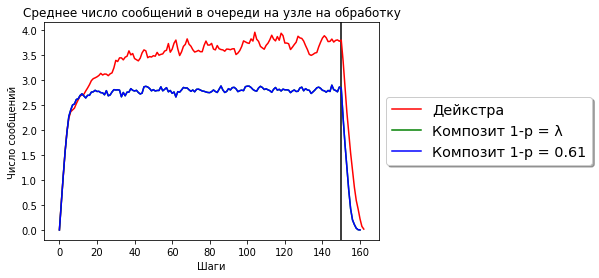

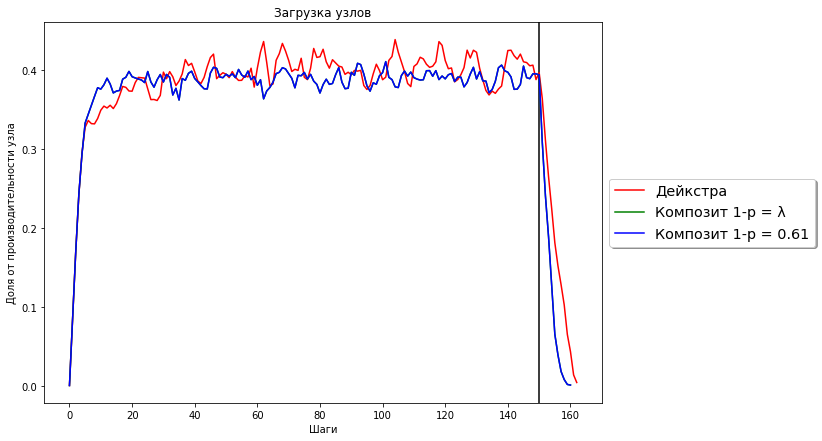

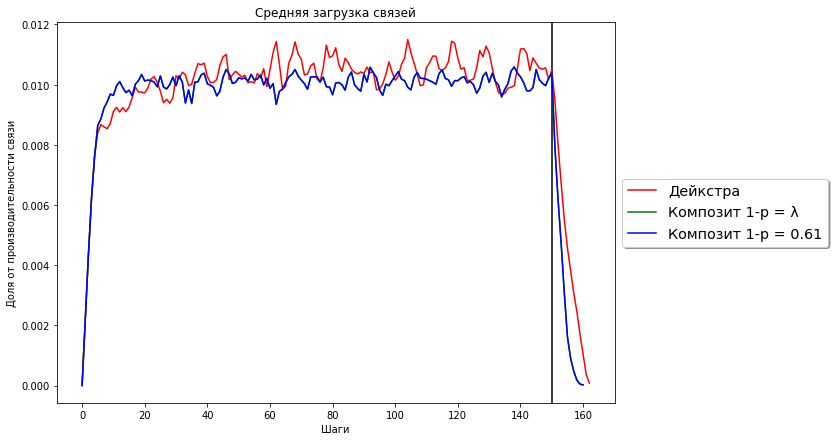

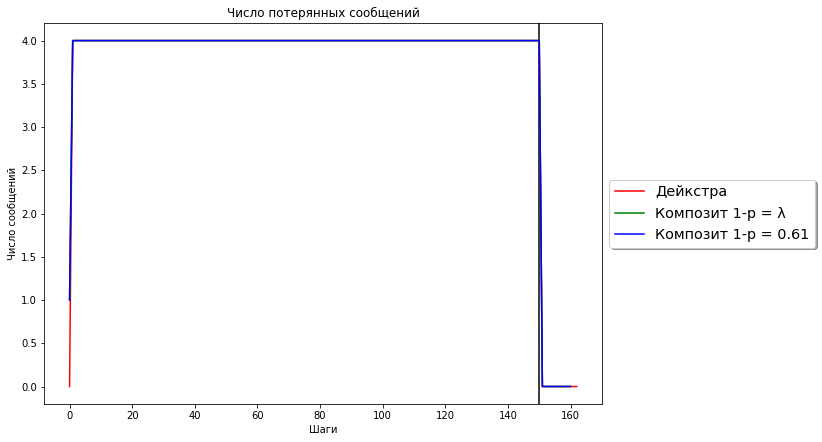

Доставлено 14401 Потеряно 3.9997% -Дейкстра
Доставлено 14400 Потеряно 4.0064% -Композит 1-p = λ
Доставлено 14400 Потеряно 4.0064% -Композит 1-p = 0.61


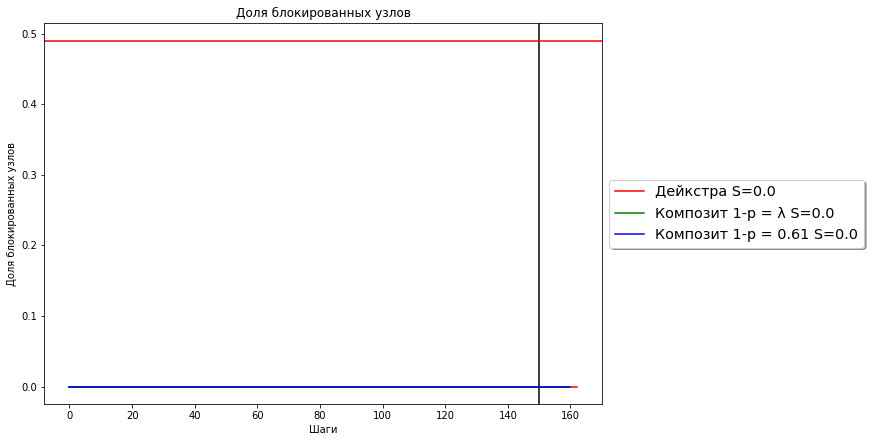

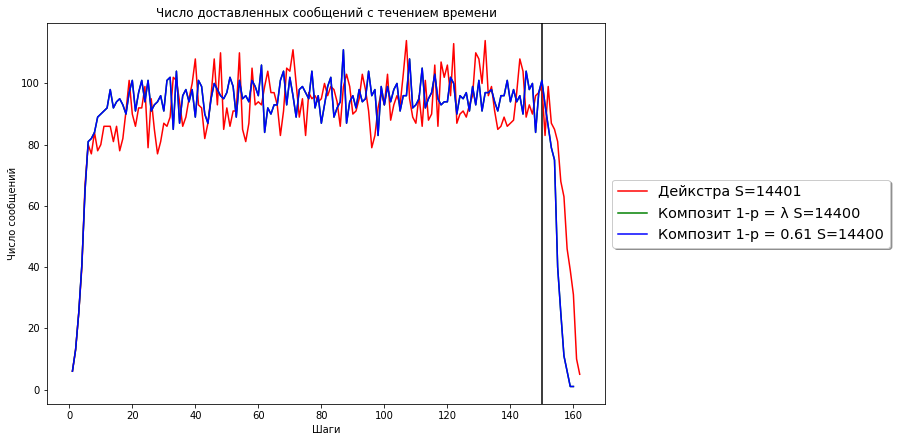

In [3]:
log_tags = [
 {"tag":  "d87a2a1b-b325-4f11-98a1-f4f50c5aeaff", "label": "Дейкстра", "color": "red"},
 #{"tag":  "41102665-f5b4-4dc5-b759-c5ab083ee254", "label": "Композит 1-p = 0.95", "color": "magenta"},
 {"tag":  "6aa7929f-f6e9-4714-8215-50c09d580588", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "00769bdc-cead-4b7c-a663-0ea102195b16", "label": "Композит 1-p = 0.61", "color": "blue"},
    #  magenta red green black
 
]     
quantity = 100;

showStat()
showStatBlocked();  
showStatMessage(); 


<strong>Quantity 500 </strong>

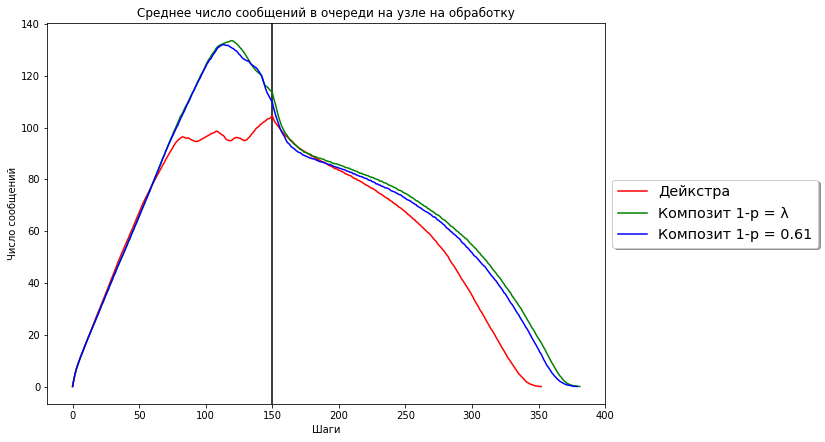

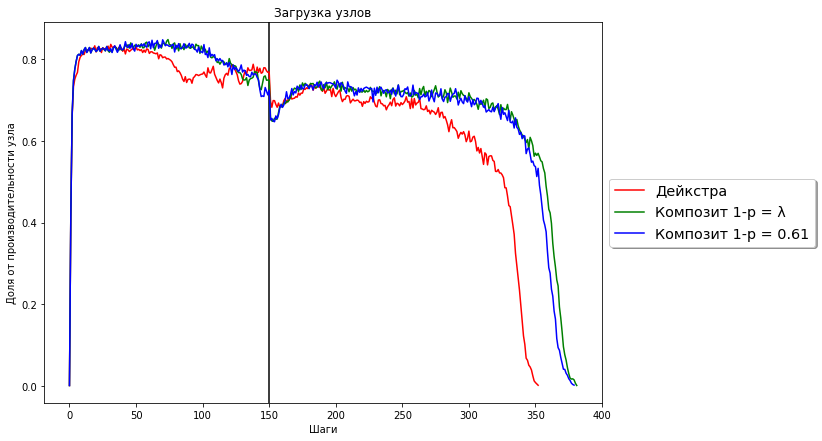

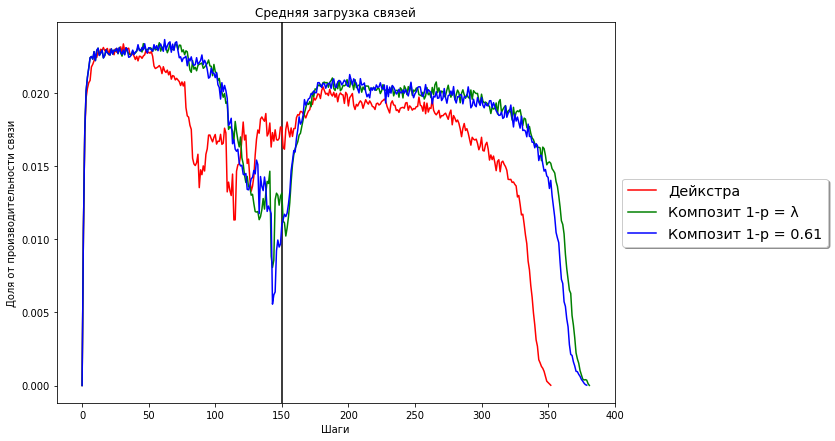

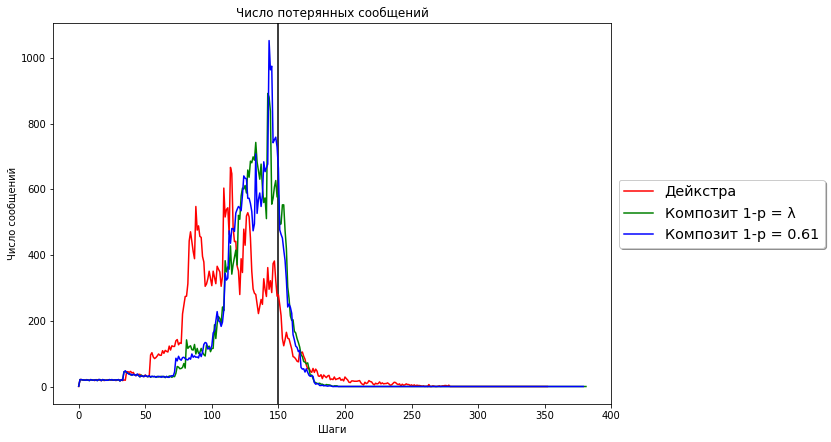

Доставлено 39356 Потеряно 47.5260% -Дейкстра
Доставлено 39360 Потеряно 47.5207% -Композит 1-p = λ
Доставлено 39263 Потеряно 47.6500% -Композит 1-p = 0.61


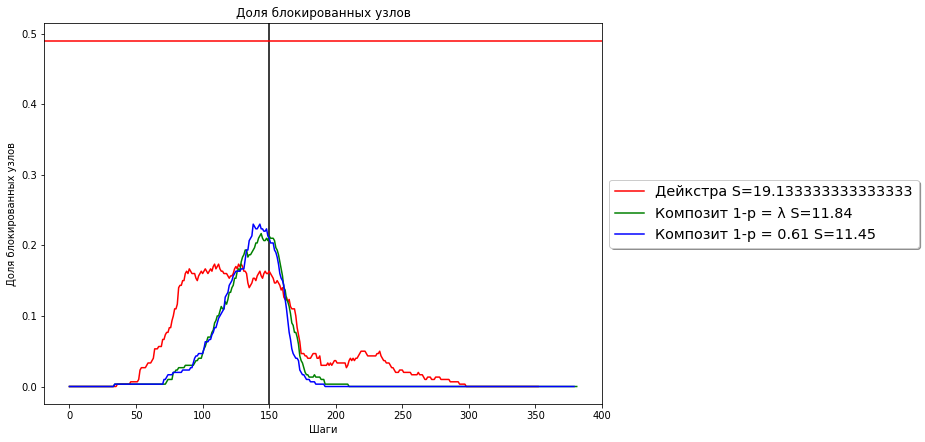

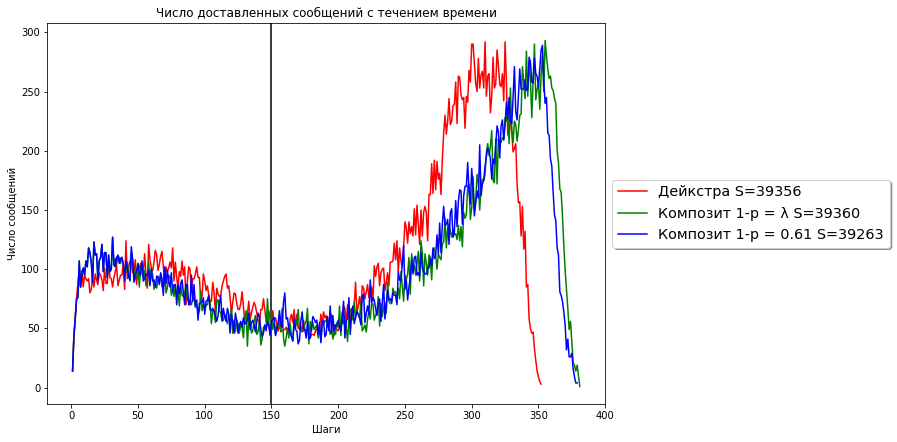

In [4]:
log_tags = [
 {"tag":  "24eae546-dd76-4b84-907f-c1db7ae71511", "label": "Дейкстра", "color": "red"},
 #{"tag":  "fbd38502-b94e-4317-b534-3d205f59142c", "label": "Композит 1-p = 0.95", "color": "m"},
 {"tag":  "523142aa-fef0-46d7-83db-af4ff6de9587", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "f7b92579-4a23-4185-a784-eed03d00f3fc", "label": "Композит 1-p = 0.61", "color": "blue"},
]
quantity = 500;  
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

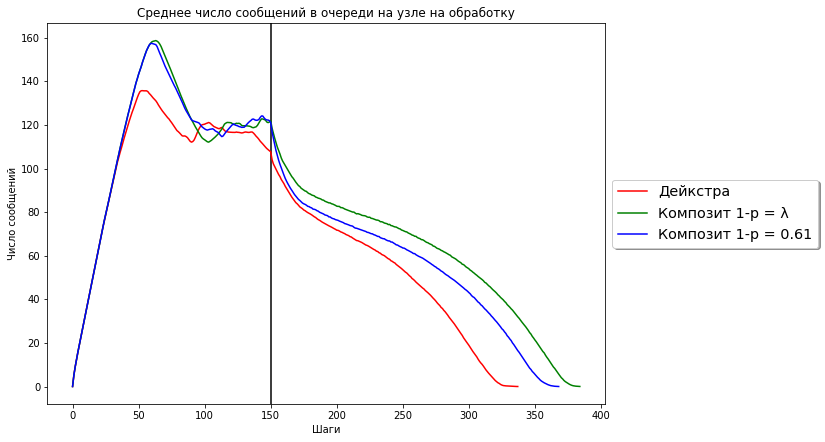

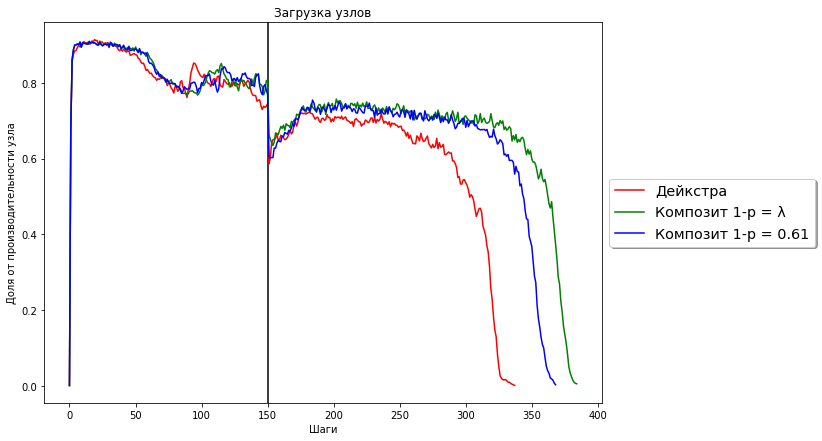

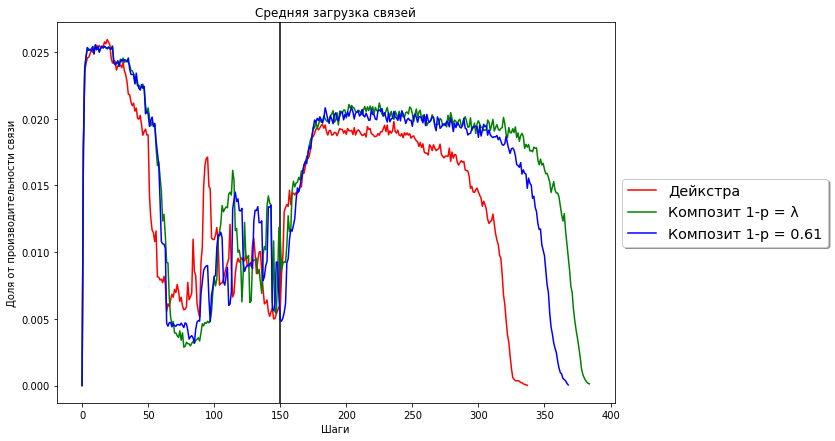

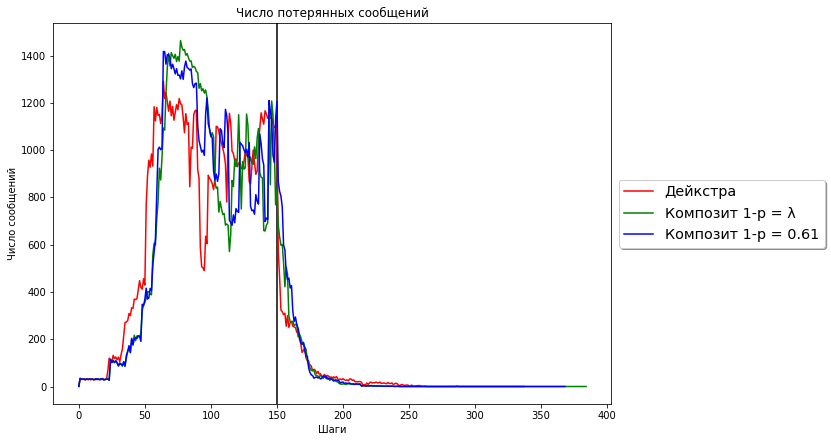

Доставлено 32061 Потеряно 78.6261% -Дейкстра
Доставлено 34490 Потеряно 77.0068% -Композит 1-p = λ
Доставлено 33075 Потеряно 77.9501% -Композит 1-p = 0.61


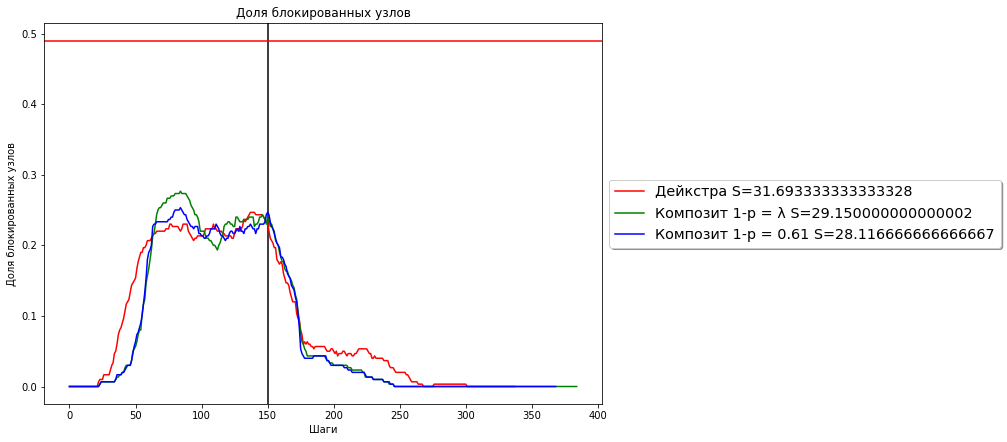

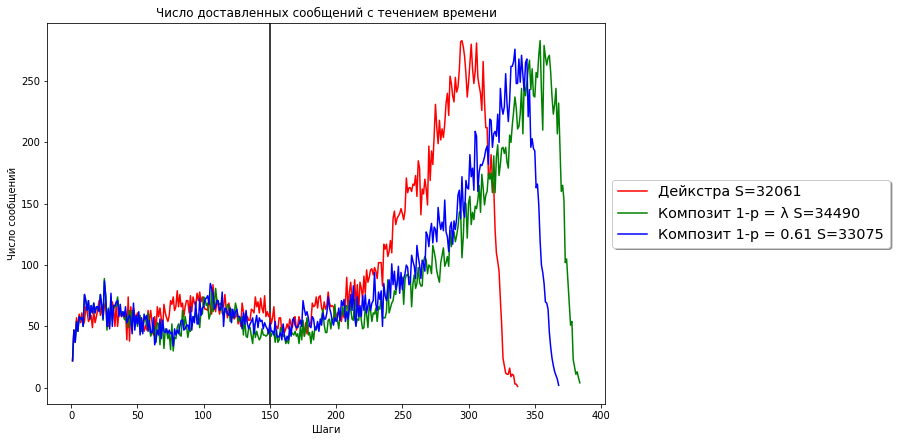

In [5]:
log_tags = [
 {"tag":  "0b30360f-11a3-4dca-bfcd-eb4ce03187cf", "label": "Дейкстра", "color": "red"},
 #{"tag":  "5fd9539d-b6a4-4ea9-bf26-6475713040ac", "label": "Композит 1-p = 0.95", "color": "m"},
 {"tag":  "7375da9b-90e9-4dd2-a3f1-618137dc6d5d", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "66da8dba-14c1-4c90-a4fa-822cfb94583b", "label": "Композит 1-p = 0.61", "color": "blue"},
]
quantity = 1000;  
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

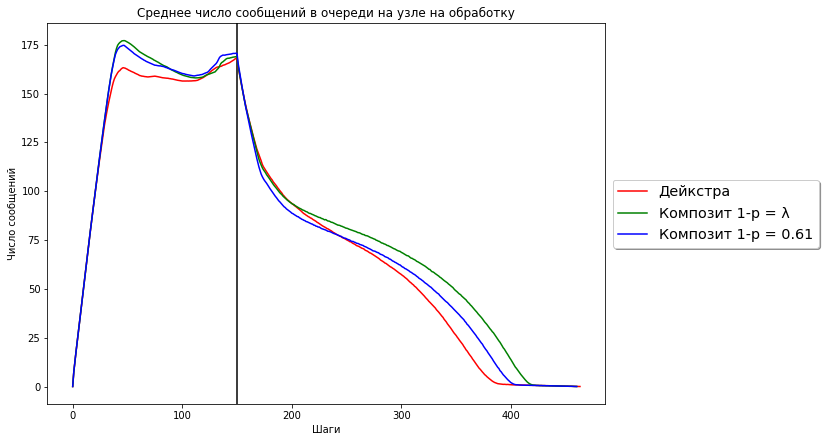

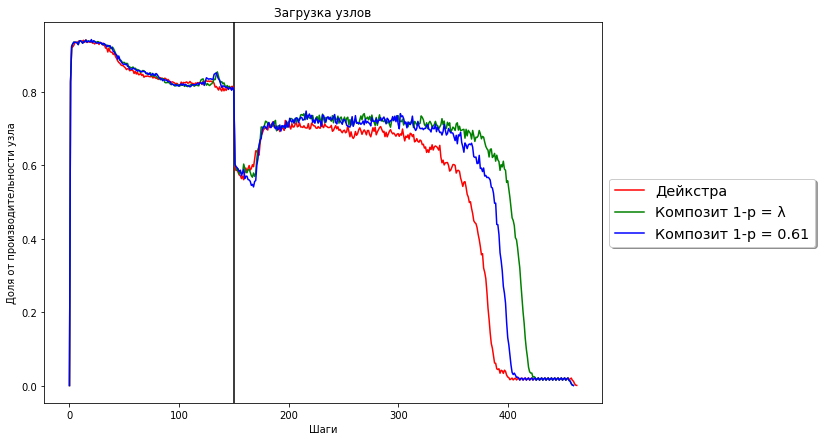

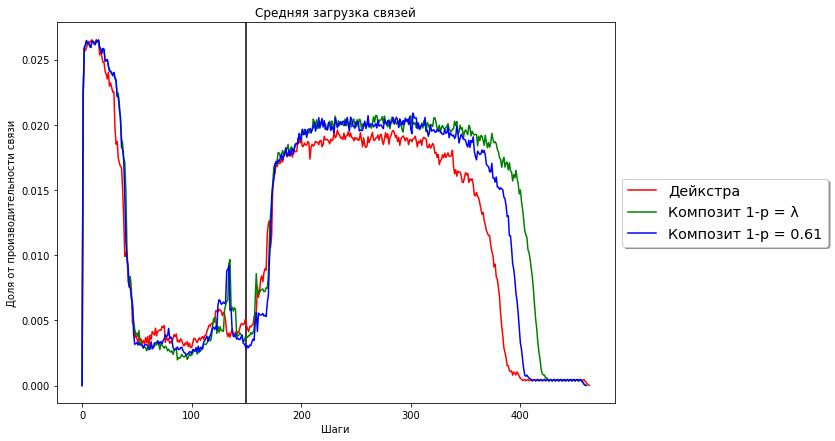

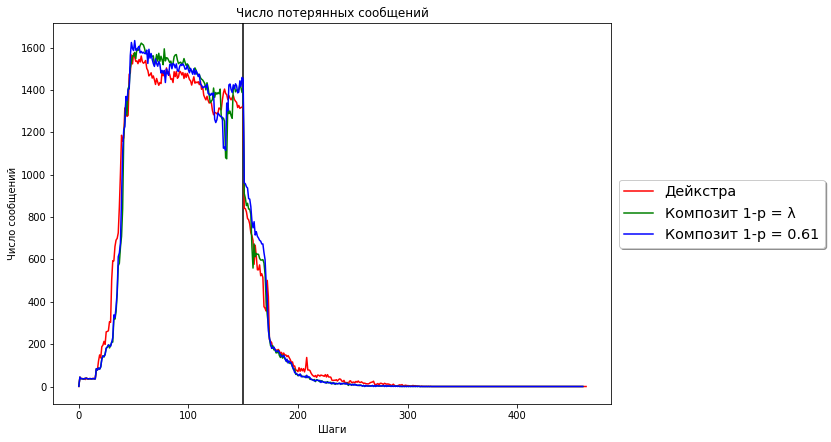

Доставлено 35631 Потеряно 84.1641% -Дейкстра
Доставлено 36433 Потеряно 83.8076% -Композит 1-p = λ
Доставлено 35003 Потеряно 84.4432% -Композит 1-p = 0.61


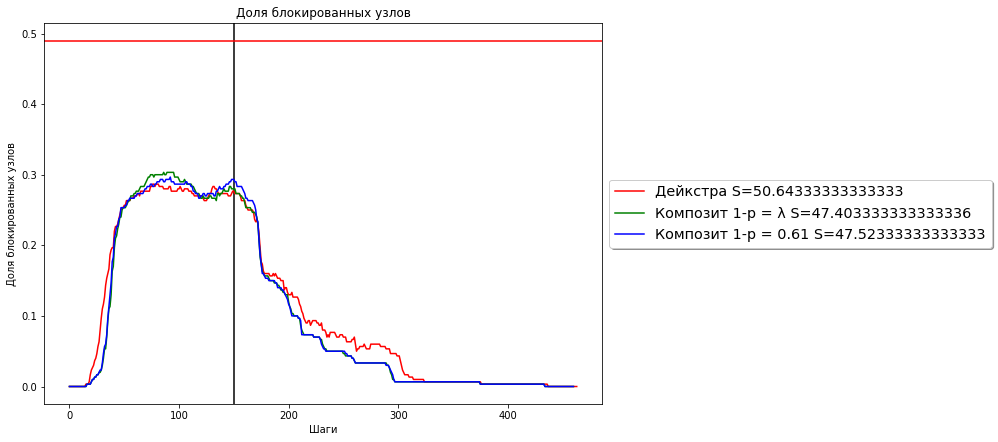

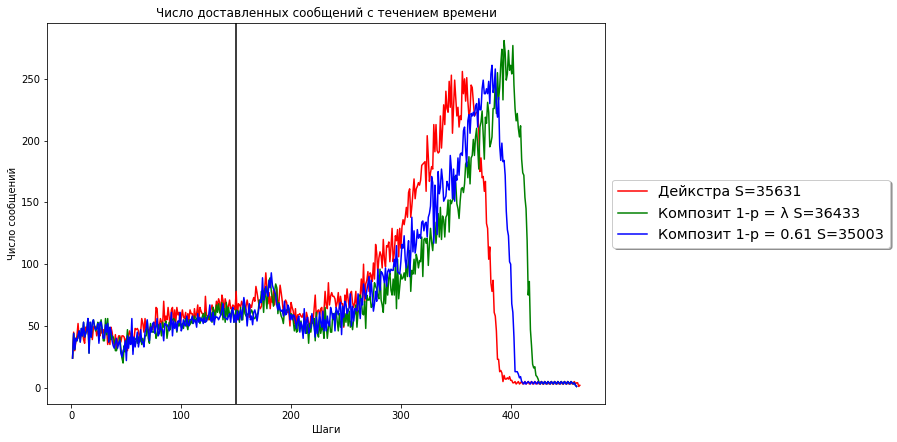

In [6]:
log_tags = [
 {"tag":  "f203e5a8-92a7-4c88-b6d3-4eff3aec7dbc", "label": "Дейкстра", "color": "red"},
 #{"tag":  "ec3d1521-bf86-4069-95ac-7b168d05a92c", "label": "Композит 1-p = 0.95", "color": "m"},
 {"tag":  "fcb9a9b2-a01c-46ca-b22e-70062d0d09f8", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "b3d3e0ec-6386-4064-a2e5-a5cf504b8158", "label": "Композит 1-p = 0.61", "color": "blue"},
]
quantity = 1500;  
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 39771 Потеряно 11.6220% -Дейкстра
Доставлено 42158 Потеряно 6.3176% -Композит 1-p = λ
Доставлено 41846 Потеряно 7.0110% -Композит 1-p = 0.61


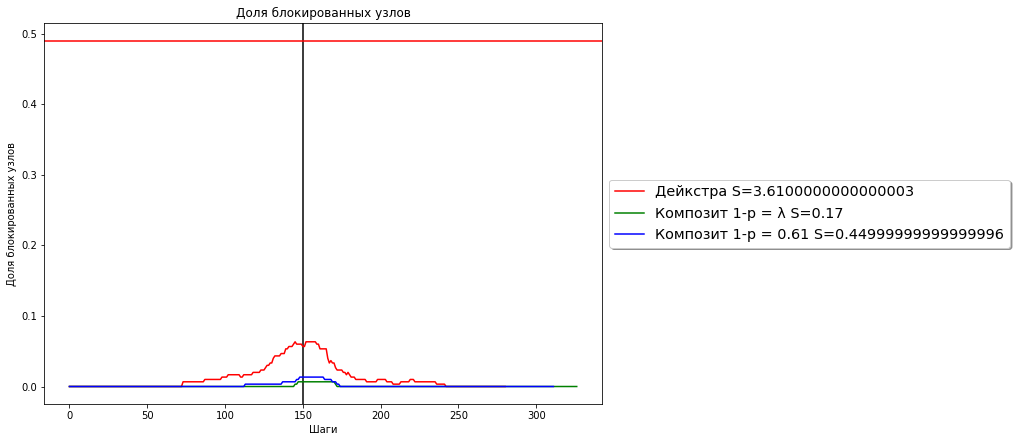

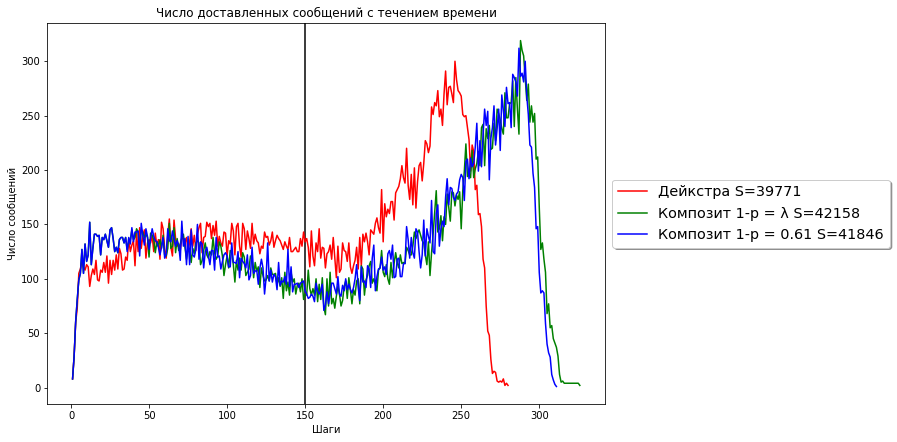

Доставлено 35836 Потеряно 65.8708% -Дейкстра
Доставлено 37173 Потеряно 64.5975% -Композит 1-p = λ
Доставлено 40727 Потеряно 61.2128% -Композит 1-p = 0.61


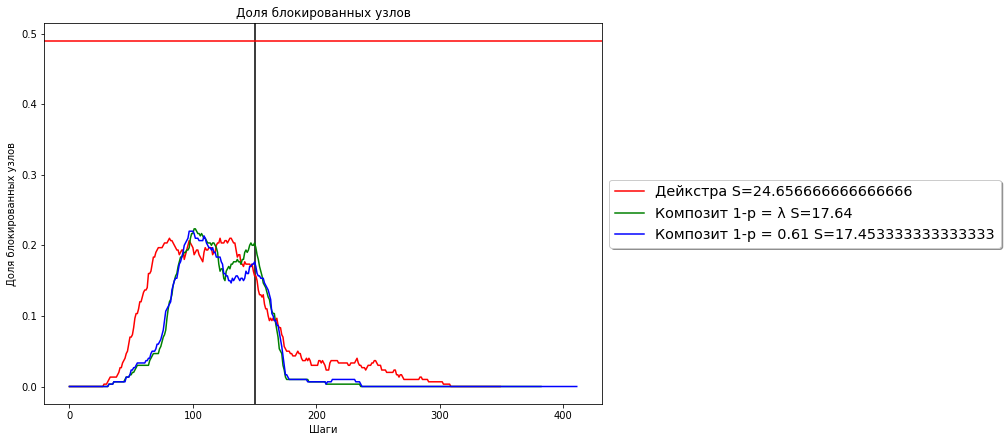

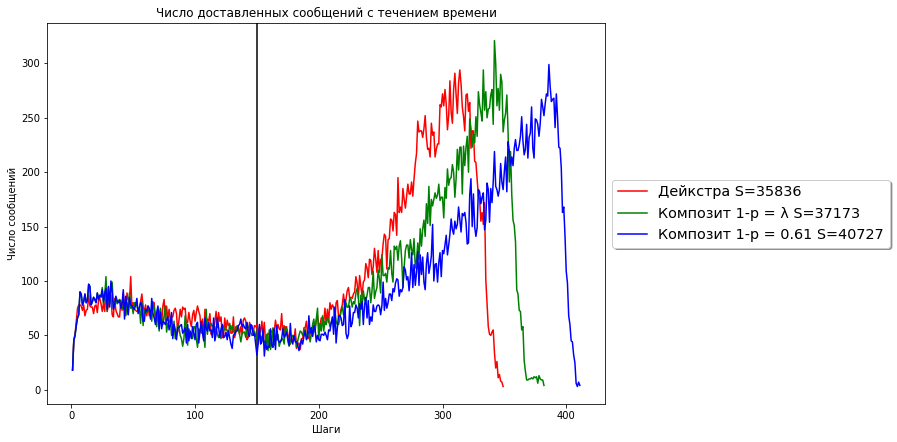

Доставлено 33355 Потеряно 75.2928% -Дейкстра
Доставлено 33390 Потеряно 75.2668% -Композит 1-p = λ
Доставлено 33798 Потеряно 74.9646% -Композит 1-p = 0.61


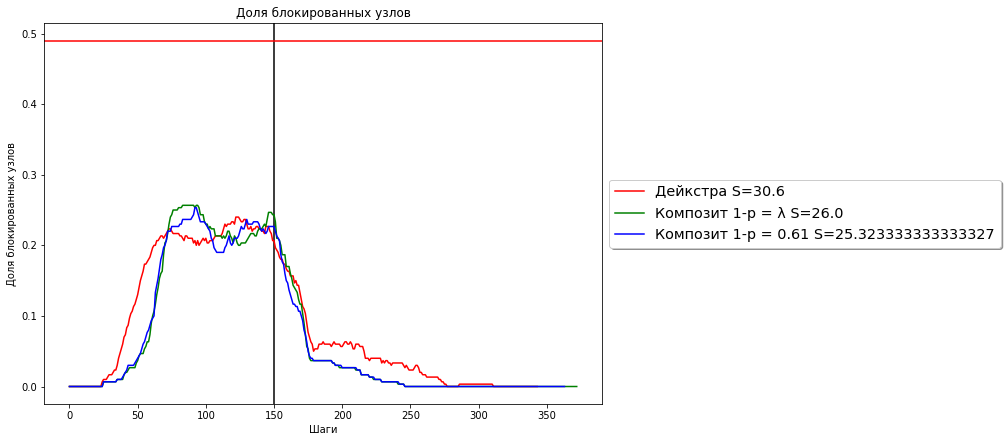

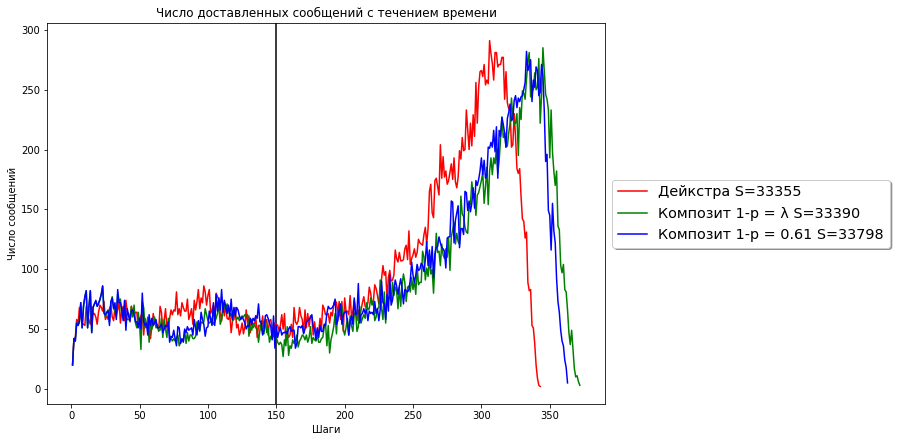

Доставлено 33221 Потеряно 82.9637% -Дейкстра
Доставлено 34238 Потеряно 82.4421% -Композит 1-p = λ
Доставлено 34138 Потеряно 82.4934% -Композит 1-p = 0.61


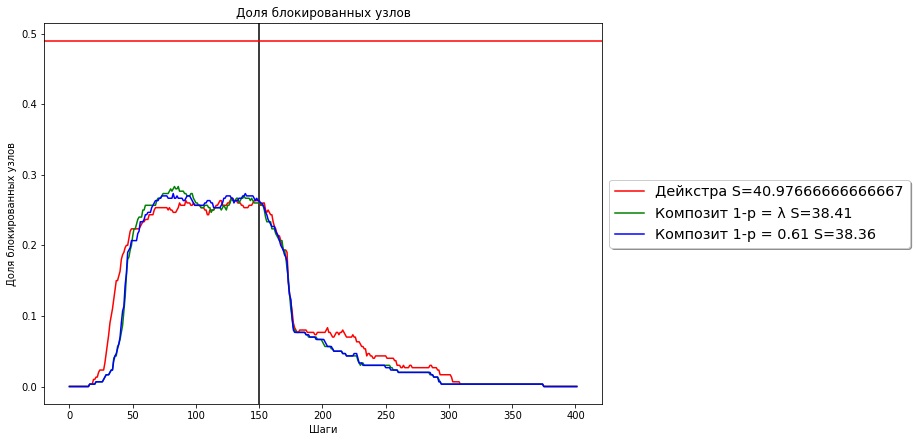

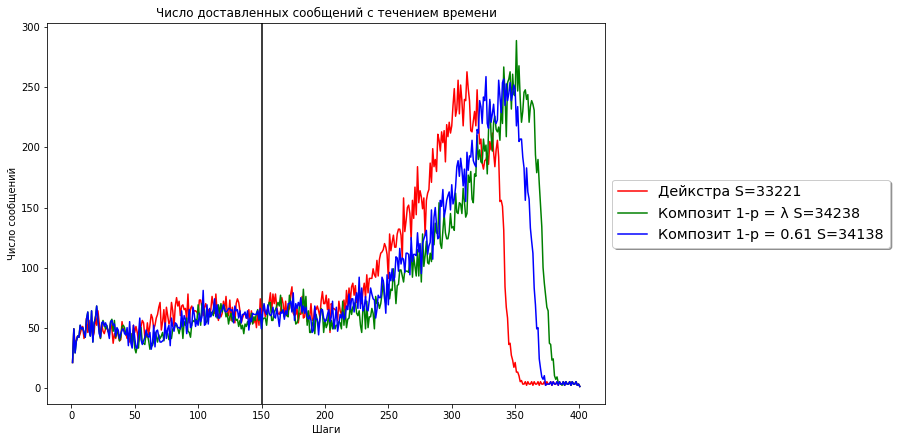

In [7]:
quantity = 300;  
log_tags = [
 {"tag":  "e9a89364-476d-48f9-aa23-d677e16ddf8f", "label": "Дейкстра", "color": "red"},
 {"tag":  "8758fe08-82ea-4e40-9d37-7c6c1a2e3e9d", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "cd31db67-1e5d-44f8-8d41-d49881a26b6a", "label": "Композит 1-p = 0.61", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "cfbde3ad-2890-48a1-8426-d636ebc695b3", "label": "Дейкстра", "color": "red"},
 {"tag":  "dac49f82-a7c4-42c1-b36c-9dac955c6c60", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "12a7baa4-b5cb-4f26-a913-c1e471acd305", "label": "Композит 1-p = 0.61", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "31d3ed5c-e278-4736-ac01-43b88ee9b5c1", "label": "Дейкстра", "color": "red"},
 {"tag":  "bd79507c-6131-4342-85ba-c4424db5fe1e", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "fc31c798-0722-4c0d-978b-5c8c959f124a", "label": "Композит 1-p = 0.61", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 1300;  
log_tags = [
 {"tag":  "3229ca98-eb72-4f73-a0e0-af1019f28675", "label": "Дейкстра", "color": "red"},
 {"tag":  "1a3205b3-8802-48e0-ae59-15d66267be26", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "b3394aad-e8c6-40bd-875b-374d16e94a87", "label": "Композит 1-p = 0.61", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

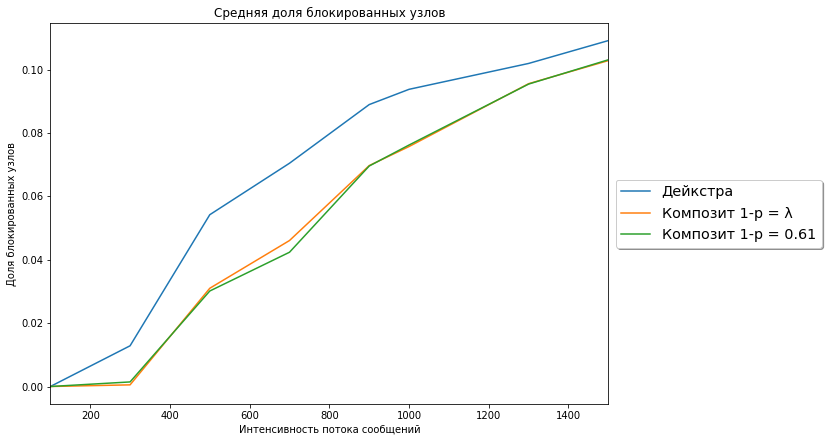

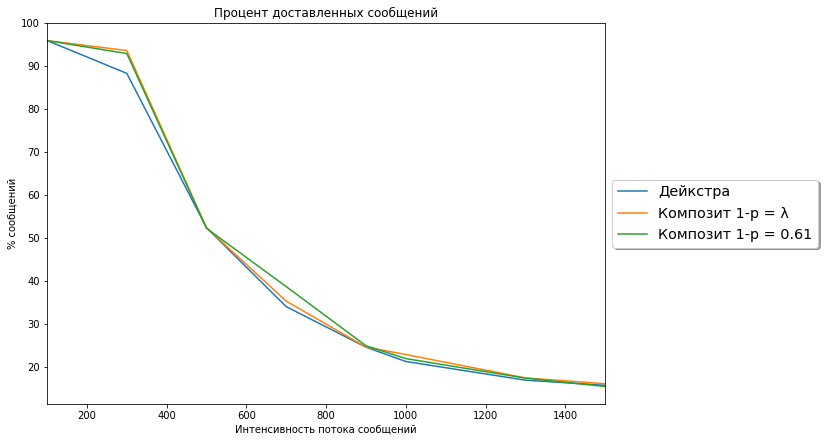

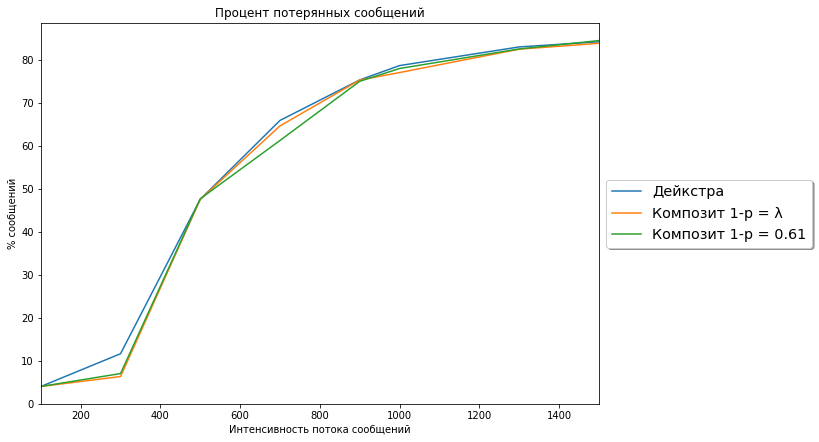

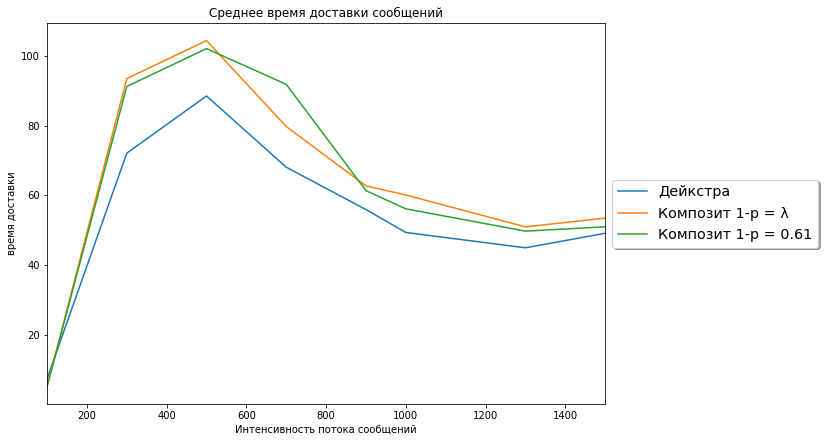

In [8]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()




In [9]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())


Дейкстра               0.066412
Композит 1-p = λ       0.052671
Композит 1-p = 0.61    0.052277

Дейкстра               56.258150
Композит 1-p = λ       55.120707
Композит 1-p = 0.61    54.966440

Дейкстра               54.432126
Композит 1-p = λ       63.767747
Композит 1-p = 0.61    63.580825
